In [1]:
!git clone https://gitlab.com/bigirqu/quranqa.git
!pip install git+https://github.com/neuml/txtai datasets pandas
!pip install farasapy

import sys
sys.path.insert(1, './quranqa/code')
import read_write_qrcd
import quranqa22_eval

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from txtai.pipeline import HFTrainer
import torch, string, re, os, json
import operator
import numpy as np


from farasa.pos import FarasaPOSTagger 
from farasa.ner import FarasaNamedEntityRecognizer 
from farasa.diacratizer import FarasaDiacritizer 
from farasa.segmenter import FarasaSegmenter 
from farasa.stemmer import FarasaStemmer




Cloning into 'quranqa'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 247 (delta 29), reused 71 (delta 22), pack-reused 163
Receiving objects: 100% (247/247), 241.68 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (83/83), done.
  Cloning https://github.com/neuml/txtai to /tmp/pip-req-build-9eiwtbgu
  Running command git clone -q https://github.com/neuml/txtai /tmp/pip-req-build-9eiwtbgu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 325 kB 3.9 MB/s 
     |████████████████████████████████| 8.6 MB 78.7 MB/s 
     |████████████████████████████████| 3.8 MB 60.1 MB/s 
     |████████████████████████████████| 596 kB 88.9 MB/s 
     |████████████████████████████████| 6.5 MB 74.4 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████

In [2]:
train_passage_question_objects = read_write_qrcd.read_JSONL_file('./quranqa/datasets/qrcd_v1.1_train.jsonl')
dev_passage_question_objects = read_write_qrcd.read_JSONL_file('./quranqa/datasets/qrcd_v1.1_dev.jsonl')


train_data = [dict({"pq_id": passage_question_object.pq_id,
                    "question": quranqa22_eval.normalize_text(passage_question_object.question),
                    "context": passage_question_object.passage, 
                    "answers": r.text})
              for passage_question_object in train_passage_question_objects
              for r in passage_question_object.answers]


dev_data = [dict({"pq_id": passage_question_object.pq_id,
                  "question": quranqa22_eval.normalize_text(passage_question_object.question),
                  "context": passage_question_object.passage,
                  "answers": r.text})
            for passage_question_object in dev_passage_question_objects
            for r in passage_question_object.answers]



Loaded 710 records from ./quranqa/datasets/qrcd_v1.1_train.jsonl
pq_id: 2:8-16_364
pq_id: 2:174-176_364
pq_id: 14:47-52_364
pq_id: 17:12-17_364
pq_id: 18:29-31_364
pq_id: 27:89-93_364
pq_id: 30:38-41_364
pq_id: 39:38-41_364
pq_id: 91:1-10_364
pq_id: 2:8-16_378
pq_id: 2:174-176_378
pq_id: 2:277-281_378
pq_id: 2:284-286_378
pq_id: 5:48-50_378
pq_id: 6:27-32_378
pq_id: 6:100-105_378
pq_id: 6:148-150_378
pq_id: 14:47-52_378
pq_id: 16:35-40_378
pq_id: 17:12-17_378
pq_id: 18:29-31_378
pq_id: 27:89-93_378
pq_id: 30:38-41_378
pq_id: 35:15-18_378
pq_id: 39:38-41_378
pq_id: 41:45-48_378
pq_id: 42:27-31_378
pq_id: 45:12-15_378
pq_id: 47:1-6_378
pq_id: 67:1-5_378
pq_id: 73:15-19_378
pq_id: 74:32-48_378
pq_id: 76:23-31_378
pq_id: 78:38-40_378
pq_id: 81:15-29_378
pq_id: 91:1-10_378
pq_id: 2:17-20_343
pq_id: 10:3-6_343
pq_id: 24:35-38_343
pq_id: 2:25-25_143
pq_id: 55:46-78_143
pq_id: 56:11-26_143
pq_id: 56:27-40_143
pq_id: 2:26-27_231
pq_id: 2:49-52_231
pq_id: 2:53-57_231
pq_id: 2:63-66_231
pq_id: 2:

In [3]:
train_pq_id = []
train_contexts = []
train_questions = []
train_answers = []

val_pq_id = []
val_contexts = []
val_questions = []
val_answers = []

In [4]:
for row in train_data:
    train_pq_id.append(row['pq_id'])
    train_contexts.append(row['context'])
    train_questions.append(row['question'])
    train_answers.append({'text': row['answers'], 'answer_start': row['context'].find(row['answers'])})
for row in dev_data:
    val_pq_id.append(row['pq_id'])
    val_contexts.append(row['context'])
    val_questions.append(row['question'])
    val_answers.append({'text': row['answers'], 'answer_start': row['context'].find(row['answers'])})


In [5]:
def dump_index(index):
  print("train_questions",train_questions[index])  
  print("train_answers",train_answers[index])
  print("val_question:",val_questions[index])
  print("val_answers:",val_answers[index])
  


In [6]:
dump_index(0)

train_questions لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان يضلل الله فما له هاد كما ورد قوله تعالى آية 23 و آية 36 سورة الزمر
train_answers {'text': 'أولئك الذين اشتروا الضلالة بالهدى', 'answer_start': 504}
val_question: ما هي مصارف الزكاة
val_answers: {'text': 'للفقراء والمساكين والعاملين عليها والمؤلفة قلوبهم وفي الرقاب والغارمين وفي سبيل الله وابن السبيل', 'answer_start': 13}


In [7]:
#dump_index(1)
dump_index(2)

train_questions لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان يضلل الله فما له هاد كما ورد قوله تعالى آية 23 و آية 36 سورة الزمر
train_answers {'text': 'ليجزي الله كل نفس ما كسبت', 'answer_start': 192}
val_question: متى يحل الإسلام دم الشخص
val_answers: {'text': 'قاتلوا في سبيل الله الذين يقاتلونكم', 'answer_start': 1}


In [8]:
dump_index(3)

train_questions لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان يضلل الله فما له هاد كما ورد قوله تعالى آية 23 و آية 36 سورة الزمر
train_answers {'text': 'كل إنسان ألزمناه طائره في عنقه', 'answer_start': 141}
val_question: متى يحل الإسلام دم الشخص
val_answers: {'text': 'قاتلوا في سبيل الله', 'answer_start': 136}


In [9]:
#for ii in range(len(train_questions)):
#  print(ii,"-----------------")
#  dump_index(ii)

In [10]:
#for ii in range(len(train_questions)):
#  print(ii,"-----------------")
#  dump_index(ii)

import pandas as pd
train_df = pd.DataFrame()
val_df = pd.DataFrame()
train_df["train_questions"] =train_questions 
train_df["train_answers"] =train_answers 
val_df["val_questions"] =val_questions 
val_df["val_answers"] =val_answers  
train_df

,train_questions,train_answers
0,لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ...,"{'text': 'أولئك الذين اشتروا الضلالة بالهدى', ..."
1,لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ...,{'text': 'أولئك الذين اشتروا الضلالة بالهدى وا...
2,لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ...,"{'text': 'ليجزي الله كل نفس ما كسبت', 'answer_..."
3,لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ...,"{'text': 'كل إنسان ألزمناه طائره في عنقه', 'an..."
4,لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان ...,{'text': 'من اهتدى فإنما يهتدي لنفسه ومن ضل فإ...
...,...,...
856,هل تحدث سيدنا محمد مع الجن,"{'text': 'قل أوحي إلي أنه استمع نفر من الجن', ..."
857,ما هي كفارة الظهار,{'text': 'تحرير رقبة من قبل أن يتماسا ذلكم توع...
858,هم المطففون,{'text': 'الذين إذا اكتالوا على الناس يستوفون....
859,ما هو فضل ليلة القدر,{'text': 'ليلة القدر خير من ألف شهر. تنزل المل...


In [11]:
#TODO
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [12]:
print(train_contexts[0])
print("\n\ntrain_questions:",train_questions[0])
print(train_answers[0])

ومن الناس من يقول آمنا بالله وباليوم الآخر وما هم بمؤمنين. يخادعون الله والذين آمنوا وما يخدعون إلا أنفسهم وما يشعرون. في قلوبهم مرض فزادهم الله مرضا ولهم عذاب أليم بما كانوا يكذبون. وإذا قيل لهم لا تفسدوا في الأرض قالوا إنما نحن مصلحون. ألا إنهم هم المفسدون ولكن لا يشعرون. وإذا قيل لهم آمنوا كما آمن الناس قالوا أنؤمن كما آمن السفهاء ألا إنهم هم السفهاء ولكن لا يعلمون. وإذا لقوا الذين آمنوا قالوا آمنا وإذا خلوا إلى شياطينهم قالوا إنا معكم إنما نحن مستهزئون. الله يستهزئ بهم ويمدهم في طغيانهم يعمهون. أولئك الذين اشتروا الضلالة بالهدى فما ربحت تجارتهم وما كانوا مهتدين.


train_questions: لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان يضلل الله فما له هاد كما ورد قوله تعالى آية 23 و آية 36 سورة الزمر
{'text': 'أولئك الذين اشتروا الضلالة بالهدى', 'answer_start': 504, 'answer_end': 537}


In [13]:
starts = [t["answer_start"] for t in train_answers]
ends = [t["answer_end"] for t in train_answers]
print("starts",starts)
print("ends",ends)
#[t["answer_start"] for t in train_answers]
#[t["answer_end"] for t in train_answers]
starts0s = [t for t in starts if t == 0]
print(len(starts0s))

starts [504, 152, 192, 141, 252, 18, 215, 307, 313, 108, 504, 152, 334, 278, 191, 308, 291, 0, 192, 1, 141, 252, 18, 216, 307, 242, 313, 91, 233, 231, 360, 43, 178, 76, 108, 247, 89, 253, 108, 29, 301, 0, 151, 600, 636, 272, 237, 129, 34, 202, 98, 348, 208, 44, 44, 185, 111, 203, 96, 75, 90, 129, 29, 105, 53, 414, 171, 179, 173, 155, 16, 32, 134, 150, 84, 205, 212, 91, 480, 283, 258, 266, 273, 286, 216, 385, 142, 312, 367, 69, 143, 85, 97, 23, 23, 295, 231, 385, 392, 400, 260, 195, 104, 61, 218, 196, 90, 121, 83, 144, 4, 191, 532, 71, 46, 340, 408, 133, 256, 6, 30, 32, 41, 711, 44, 43, 81, 305, 103, 240, 151, 211, 48, 43, 166, 29, 33, 53, 114, 16, 239, 59, 26, 70, 12, 363, 8, 139, 127, 58, 71, 233, 265, 139, 191, 130, 144, 322, 23, 46, 0, 4, 213, 270, 451, 0, 122, 143, 8, 8, 330, 0, 0, 0, 60, 282, 209, 11, 12, 231, 109, 165, 11, 165, 257, 1, 203, 58, 1, 133, 253, 93, 60, 1, 116, 86, 130, 269, 38, 359, 5, 566, 280, 76, 206, 159, 16, 16, 125, 5, 356, 56, 9, 42, 302, 98, 10, 186, 16, 159,

In [14]:
#Open to see question and context
#for q,a in zip( val_questions, val_answers):
#  print(":",q)
#  print( a["text"])

In [15]:
#Open comment to see question and answer
#for q,a in zip( train_questions, train_answers):
#  print(q)
#  print( a["text"])

In [16]:
print(type(train_contexts))
print(type(train_questions))
print(train_contexts[0])
print(train_questions[0] )

<class 'list'>
<class 'list'>
ومن الناس من يقول آمنا بالله وباليوم الآخر وما هم بمؤمنين. يخادعون الله والذين آمنوا وما يخدعون إلا أنفسهم وما يشعرون. في قلوبهم مرض فزادهم الله مرضا ولهم عذاب أليم بما كانوا يكذبون. وإذا قيل لهم لا تفسدوا في الأرض قالوا إنما نحن مصلحون. ألا إنهم هم المفسدون ولكن لا يشعرون. وإذا قيل لهم آمنوا كما آمن الناس قالوا أنؤمن كما آمن السفهاء ألا إنهم هم السفهاء ولكن لا يعلمون. وإذا لقوا الذين آمنوا قالوا آمنا وإذا خلوا إلى شياطينهم قالوا إنا معكم إنما نحن مستهزئون. الله يستهزئ بهم ويمدهم في طغيانهم يعمهون. أولئك الذين اشتروا الضلالة بالهدى فما ربحت تجارتهم وما كانوا مهتدين.
لماذا سيُحاسب ويُعذب الضال يوم القيامة ان كان يضلل الله فما له هاد كما ورد قوله تعالى آية 23 و آية 36 سورة الزمر


In [17]:
model_name = "wissamantoun/araelectra-base-artydiqa" #num_train_epochs=2
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

Downloading:   0%|          | 0.00/390 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
tokenizer

PreTrainedTokenizerFast(name_or_path='wissamantoun/araelectra-base-artydiqa', vocab_size=64000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [19]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:          
            #print("start_positions minus,",answers[i])
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            #print("end_positions minus,",answers[i])
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [20]:
len(train_encodings["start_positions"])

861

In [21]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)



In [22]:
def normalize_text(s):
    """remove punctuation, some stopwords and extra whitespace."""
    def remove_stopWords(text):
        terms = []
        stopWords = {'من', 'الى', 'إلى', 'عن', 'على', 'في', 'حتى'}
        for term in text.split():
            if term not in stopWords:
                terms.append(term)
        return " ".join(terms)

    def white_space_fix(text):
        return ' '.join(text.split())



In [28]:
model_name = "wissamantoun/araelectra-base-artydiqa" #num_train_epochs=2
tokenizer = AutoTokenizer.from_pretrained(model_name)


def model_init():
    return AutoModelForQuestionAnswering.from_pretrained(model_name)

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = [tokenizer.decode(pred) for pred in prediction]
    print(truth)
    print(prediction)
    print(pred_tokens)
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    exact_match = compute_exact_match(pred, labels)
    f1 = compute_f1(pred, labels)

    return { "f1": f1, "exact_match": exact_match}


loading configuration file https://huggingface.co/wissamantoun/araelectra-base-artydiqa/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/55a8daa010dc1d78ef83f5ed6b332eca6025d20451b85164c05c07eb0420013b.c1490b0222843c10bd1a53fb4cfd4665f92f51e0d1b04fed1c9fd3eeead7247a
Model config ElectraConfig {
  "_name_or_path": "wissamantoun/araelectra-base-artydiqa",
  "architectures": [
    "ElectraForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "generator_hidden_size": 0.33333,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "firs

In [24]:
from transformers import TrainingArguments, Trainer
batch_size = 1

args = TrainingArguments(
    "outputs_dir",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    fp16=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=False, # change this to True after hyperparameter tuning
    save_strategy='no', # remove this after hyperparamenter tuning
)

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/wissamantoun/araelectra-base-artydiqa/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/55a8daa010dc1d78ef83f5ed6b332eca6025d20451b85164c05c07eb0420013b.c1490b0222843c10bd1a53fb4cfd4665f92f51e0d1b04fed1c9fd3eeead7247a
Model config ElectraConfig {
  "_name_or_path": "wissamantoun/araelectra-base-artydiqa",
  "architectures": [
    "ElectraForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "generator_hidden_size": 0.33333,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "firs

Downloading:   0%|          | 0.00/514M [00:00<?, ?B/s]

storing https://huggingface.co/wissamantoun/araelectra-base-artydiqa/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/61e89120db94682d5d1da693ae1d3e06538630aba040c8c90597c803e401e379.889c6578d804af8dbe05e5370bf304ea859c82138a57d67291f254347c02dae6
creating metadata file for /root/.cache/huggingface/transformers/61e89120db94682d5d1da693ae1d3e06538630aba040c8c90597c803e401e379.889c6578d804af8dbe05e5370bf304ea859c82138a57d67291f254347c02dae6
loading weights file https://huggingface.co/wissamantoun/araelectra-base-artydiqa/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/61e89120db94682d5d1da693ae1d3e06538630aba040c8c90597c803e401e379.889c6578d804af8dbe05e5370bf304ea859c82138a57d67291f254347c02dae6
All model checkpoint weights were used when initializing ElectraForQuestionAnswering.

All the weights of ElectraForQuestionAnswering were initialized from the model checkpoint at wissamantoun/araelectra-base-artydiqa.
If your tas

In [25]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True),
    }

In [26]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 144 kB 75.5 MB/s 
     |████████████████████████████████| 181 kB 74.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [29]:
trainer.train()


loading configuration file https://huggingface.co/wissamantoun/araelectra-base-artydiqa/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/55a8daa010dc1d78ef83f5ed6b332eca6025d20451b85164c05c07eb0420013b.c1490b0222843c10bd1a53fb4cfd4665f92f51e0d1b04fed1c9fd3eeead7247a
Model config ElectraConfig {
  "_name_or_path": "wissamantoun/araelectra-base-artydiqa",
  "architectures": [
    "ElectraForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "generator_hidden_size": 0.33333,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "firs

Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 128
  Batch size = 1


Epoch,Training Loss,Validation Loss


(array([  4,   5,   1,  34,  69,  75, 104, 113,  33, 147,  52,  56,  20,
       110,   1,  39,  30,  39,  35,  73,  24,   1,  61,   1,  41,  26,
        75,  11,  21,  20,  57, 119,  62,  63,  10,  74, 101,  12,  54,
        28,   1,  84,  24,  52, 188, 166,  32,  35,  23,   4,   1,  24,
         4,  48,  92,  63,   6,  43,   1,  35,  83,  92,  36,  11,  38,
        28,   1,  50,  14,  41,  34,  51,  68,  79,   1,   4,  80,  10,
         5, 105,   1,  66,   2,  20,  56,  29,   1, 108,  36,  52,  36,
        55,   1,  63,  54,  32,  42,  85,  98,   1,  57,  22, 102,  80,
       144, 164,  64,  73,   1,   1,  18,  48,   1,  57,  32,  63,  60,
        19,   1,  32,  65,   6,  58,  86,   1,  45,  85, 143]), array([ 21,  19,   9,  39,  74,  88, 108, 123,  75, 169,  55,  59,  30,
       133,  21,  74,  39,  46,  43,  80,  29,  20,  90,  30,  56, 114,
       116,  20,  24,  32,  68, 133,  89,  75,  40,  82, 109,  62,  73,
        47,  12, 143,  47,  55, 200, 174,  37,  43,  28,  13,   7,  37,

AttributeError: ignored

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=20, direction="minimize", hp_space=hp_space)


In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name)



Downloading:   0%|          | 0.00/514M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

_ = model.to(device)

In [ ]:
def eval_loader(batch_size=16,dump_equals=False):
    t1 = time()
    model.eval()
    acc = []
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    dump_count = 0
    eval_data = []
    for batch in val_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # get top prediction with argmax
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calculate accuracy 
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

            eval_data.append( [start_pred , start_true,end_pred , end_true ])

            if dump_equals and dump_count < 14 and start_pred == start_true and end_pred == end_true:
              dump_count += 1
              tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
              pred = get_text_atrange(  tokens,start_pred[0],end_pred[0] )
              print("tokens",pred )
              print("start_pred == start_true",start_pred , start_true)
              print("end_pred == end_true",end_pred , end_true)
              print("--")
    # calculate  accuracy in total
    acc = sum(acc)/len(acc)
    t2 = time()      
    elapsed = t2 - t1
    print('Elapsed time for eval %f seconds.' % elapsed)
    return acc ,eval_data

In [ ]:
from time import time
import matplotlib.pyplot as plt

def train_model():
  t1 = time()
  model.train()
  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  optim = AdamW(model.parameters(), lr=5e-5)
  outputs_model = []
  for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        if len(outputs_model) == 0:
          outputs_model.append(outputs)
        loss = outputs[0]
        loss.backward()
        optim.step()
  t2 = time()      
  elapsed = t2 - t1
  print('Elapsed time for training %f seconds.' % elapsed)
  return outputs_model

#start_pred , start_true,end_pred , end_true
def plot_eval_old(eval_data):
  pred_x = []
  pred_y = []
  true_x = []
  true_y = []
  for e_data in eval_data:
    if e_data[3].item() - e_data[1].item() > 30:
      continue
    pred_x.append( e_data[0].item() )
    true_x.append( e_data[1].item() )
    pred_y.append( e_data[2].item() )
    true_y.append( e_data[3].item() )
  plt.scatter(pred_x,pred_y,color="blue",label="prediction")
  plt.scatter(true_x,true_y,color="orange",label="true")
  plt.legend()  
  plt.show()
  plt.plot(pred_x,pred_y,color="blue",label="prediction",linestyle='-')
  plt.plot(true_x,true_y,color="orange",label="true")
  plt.legend()
  plt.show()

def plot_eval(eval_data):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(11, 8)
  axes[0].set_title("Prediction")
  axes[1].set_title("Actual")
  axes[2].set_title("Combined")
  for index,e_data in enumerate(eval_data):
    start_pred , end_pred =  e_data[0] , e_data[2]
    start_true , end_true =  e_data[1] , e_data[3]
    
    if abs(start_true - end_true) < 100:
      axes[0].plot([index,index],[start_pred,end_pred],color="blue",linestyle='-')
      axes[1].plot([index,index],[start_true,end_true],color="orange")  

      axes[2].plot([index*2,index*2],[start_pred,end_pred],color="blue",linestyle='-')
      axes[2].plot([index*2+1,index*2+1],[start_true,end_true],color="orange")  

      #axes[3].plot([index*2+1,index*2+1],[start_true,end_true],color="orange")  
      #axes[3].plot([index*2,index*2],[start_pred,end_pred],color="blue",linestyle='-')
      
  fig.tight_layout()    

      
      

In [ ]:
acc,eval_data = eval_loader(1,dump_equals=False)
acc

Elapsed time for eval 1.454110 seconds.


0.08203125

In [ ]:
#Open if you want to see output
#outputs_model = train_model()
#outputs_model

In [ ]:


def get_text_atrange(tokens,begin,end):
  print("begin,end",begin,end)
  answer = ""
  for i in range(begin, end + 1):    
    if tokens[i][0:2] == '##': # If it's a subword token, then recombine it with the previous token.
        answer += tokens[i][2:]    
    else: # Otherwise, add a space then the token.
        answer += ' ' + tokens[i]    
  return answer

#used to combine tokens with prefix ##
def get_tokens_at_text(tokens):
  
  answer = ""
  for token in tokens:    
    if token[0:2] == '##': # If it's a subword token, then recombine it with the previous token.
        answer += token[2:]    
    else: # Otherwise, add a space then the token.
        answer += ' ' + token   
  return answer      

In [ ]:
import numpy as np
def get_top_answers(possible_starts,possible_ends,input_ids):
  answers = []
  for start,end in zip(possible_starts,possible_ends):
    #+1 for end
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start:end+1]))
    answers.append( answer )
  return answers  

def answer_question(question,context,topN):

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    model_out = model(**inputs.to(device))
     
    answer_start_scores = model_out["start_logits"]
    answer_end_scores = model_out["end_logits"]

    possible_starts = np.argsort(answer_start_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    possible_ends = np.argsort(answer_end_scores.cpu().detach().numpy()).flatten()[::-1][:topN]
    
    #get best answer
    answer_start = torch.argmax(answer_start_scores)  
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    answers = get_top_answers(possible_starts,possible_ends,input_ids )

    return { "answer":answer,"answer_start":answer_start,"answer_end":answer_end,"input_ids":input_ids,
            "answer_start_scores":answer_start_scores,"answer_end_scores":answer_end_scores,"inputs":inputs,"answers":answers,
            "possible_starts":possible_starts,"possible_ends":possible_ends}

import matplotlib.pyplot as plt

def plot_possible_answer(answer_map,expected_start,expected_end,title_postfix=""):
  start_scores = answer_map["answer_start_scores"]
  end_scores = answer_map["answer_end_scores"]
  tokens = tokenizer.decode( answer_map["input_ids"] ).split(" ") 
  #print("tokens",len(tokens),"---",len(answer_map["input_ids"]))
  tokens_ind = [ tokenizer.decode(t) for t in answer_map["input_ids"] ]
  #print("tokens_ind",len(tokens_ind))
  #print("tokens_ind",tokens_ind )
  fig,axes = plt.subplots(2,1)
  y_start = start_scores.cpu().detach().numpy().flatten()
  x_start = [i for i in range(len(y_start))]

  y_end = end_scores.cpu().detach().numpy().flatten()
  x_end = [i for i in range(len(y_end))]

  axes[0].bar(tokens_ind,y_start)
  axes[0].set_title("start scores( "+ str( len( y_start ) ) +") " + title_postfix )
  axes[0].figure.set_size_inches(10, 5)
  #axes[0].xaxis.set_labels( tokens_ind )
  axes[0].xaxis.set_tick_params(rotation=90)
  axes[0].axvline(expected_start,color="yellow")
  #print("axes[0].get_xticklabels()",axes[0].get_xticklabels())
  #axes[0].get_xticklabels()[0].set_color("yellow")
  #axes[0].set_xticklabels(tokens_ind, rotation = 90, ha="right")
  #axes[0].get_xticklabels()[expected_start].set_color("yellow")
  
  axes[1].bar(tokens_ind,y_end, color="orange")
  axes[1].set_title("end scores( "+ str( len( y_end ) ) +") " + title_postfix )
  axes[1].axvline(expected_end,color="red")
  axes[1].xaxis.set_tick_params(rotation=90)
  #axes[1].get_xticklabels()[expected_end].set_color("red")

  axes[0].autoscale(tight=True)
  axes[1].autoscale(tight=True)
  fig.tight_layout()
  #return fig   ,axes[0].get_xticklabels()         

In [ ]:
eval_loader(batch_size=1,dump_equals=True)
#no training yet so accuracy so low

acc,eval_data = eval_loader(1,dump_equals=False)
acc

begin,end tensor(1, device='cuda:0') tensor(8, device='cuda:0')
tokens  من يطع الرسول فقد أطاع الله
start_pred == start_true tensor([1], device='cuda:0') tensor([1], device='cuda:0')
end_pred == end_true tensor([8], device='cuda:0') tensor([8], device='cuda:0')
--
Elapsed time for eval 1.660926 seconds.
Elapsed time for eval 1.453921 seconds.


0.08203125

In [ ]:
def dump_validation(index):
  print( val_contexts[index] )
  print( val_questions[index] )

dump_validation(5)

فليقاتل في سبيل الله الذين يشرون الحياة الدنيا بالآخرة ومن يقاتل في سبيل الله فيقتل أو يغلب فسوف نؤتيه أجرا عظيما. وما لكم لا تقاتلون في سبيل الله والمستضعفين من الرجال والنساء والولدان الذين يقولون ربنا أخرجنا من هذه القرية الظالم أهلها واجعل لنا من لدنك وليا واجعل لنا من لدنك نصيرا. الذين آمنوا يقاتلون في سبيل الله والذين كفروا يقاتلون في سبيل الطاغوت فقاتلوا أولياء الشيطان إن كيد الشيطان كان ضعيفا.
متى يحل الإسلام دم الشخص


In [ ]:
val_questions

['ما هي مصارف الزكاة',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'متى يحل الإسلام دم الشخص',
 'ما هو سبب نزول سيدنا آدم الجنة',
 'ما هو سبب نزول سيدنا آدم الجنة',
 'ما هو سبب نزول سيدنا آدم الجنة',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا يشمل الإحسان',
 'ماذا 

In [ ]:
index = val_questions.index( 'هل هناك إسلام بدون الحديث الشريف')
question = val_questions[index] 
context = val_contexts[index] 
topN = 5
expected_start = 70 #109
expected_end = 84 #127

answer_steps = []

In [ ]:
#print("question",question)
#get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"])

question هل هناك إسلام بدون الحديث الشريف


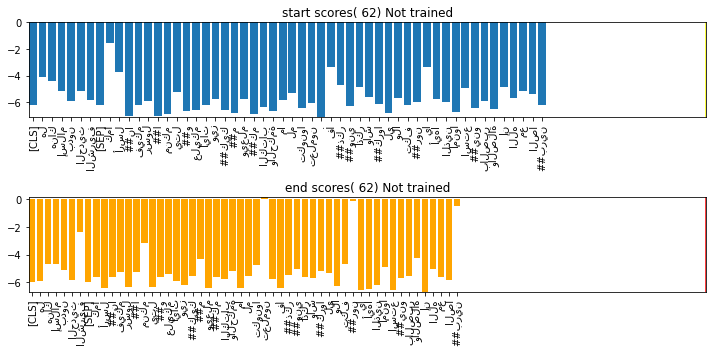

In [ ]:
print("question",question)
answer_map = answer_question(question,context,topN)
answer_steps.append( answer_map )
plot_possible_answer(answer_map,expected_start,expected_end,"Not trained")

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(answer_map["input_ids"])
for index,t in enumerate(tokens):
  if index % 10 == 0:
    print("")
  print(f"{index} ) {t}", end =" ")


0 ) [CLS] 1 ) هل 2 ) هناك 3 ) إسلام 4 ) بدون 5 ) الحديث 6 ) الشريف 7 ) [SEP] 8 ) كما 9 ) أرسل 
10 ) ##نا 11 ) فيكم 12 ) رسول 13 ) ##ا 14 ) منكم 15 ) يتل 16 ) ##و 17 ) عليكم 18 ) آيات 19 ) ##نا 
20 ) ويز 21 ) ##كيك 22 ) ##م 23 ) ويعلم 24 ) ##كم 25 ) الكتاب 26 ) والحكمة 27 ) ويعلم 28 ) ##كم 29 ) ما 
30 ) لم 31 ) تكونوا 32 ) تعلمون 33 ) . 34 ) فا 35 ) ##ذكر 36 ) ##وني 37 ) أذكر 38 ) ##كم 39 ) واش 
40 ) ##كروا 41 ) لي 42 ) ولا 43 ) تكف 44 ) ##رون 45 ) . 46 ) يا 47 ) أيها 48 ) الذين 49 ) آمنوا 
50 ) استع 51 ) ##ينو 52 ) ##ا 53 ) بالصبر 54 ) والصلاة 55 ) إن 56 ) الله 57 ) مع 58 ) الصا 59 ) ##برين 
60 ) . 61 ) [SEP] 

In [ ]:
_ = train_model()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Elapsed time for training 38.402420 seconds.


question هل هناك إسلام بدون الحديث الشريف
يا أيها الذين آمنوا استعينوا بالصبر والصلاة إن الله مع الصابرين
بالصبر والصلاة
الذين آمنوا
كما أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون. فاذكروني أذكركم واشكروا لي ولا تكفرون



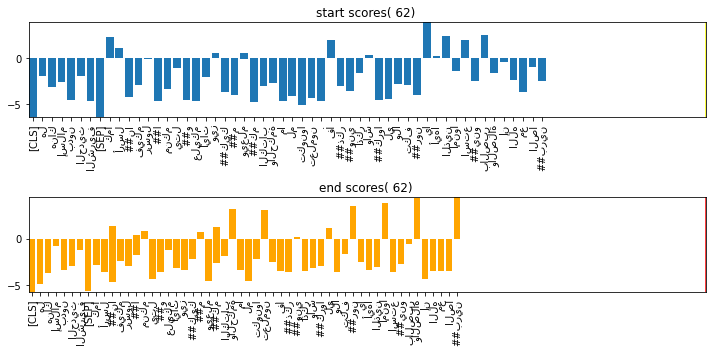

In [ ]:
print("question",question)
answer_map = answer_question(question,context,topN)
answer_steps.append( answer_map )
print( "\n".join( get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"]) ) )
plot_possible_answer(answer_map,expected_start,expected_end)

In [ ]:
acc,eval_data = eval_loader(1,dump_equals=False)
print("accuracy eval :",acc)

Elapsed time for eval 1.475759 seconds.
accuracy eval : 0.3125


In [ ]:
_ = train_model()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Elapsed time for training 38.343538 seconds.


Question هل هناك إسلام بدون الحديث الشريف
أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة
كما أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون
فاذكروني أذكركم واشكروا لي ولا تكفرون. يا أيها الذين آمنوا استعينوا بالصبر والصلاة




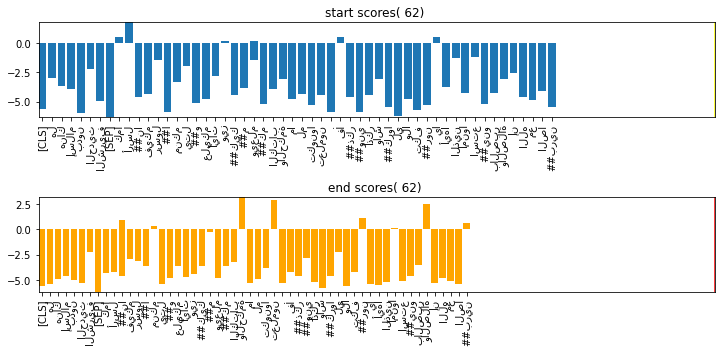

In [ ]:
print("Question",question)
answer_map = answer_question(question,context,topN)
answer_steps.append( answer_map )
print( "\n".join( get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"]) ) )
plot_possible_answer(answer_map,expected_start,expected_end)

In [ ]:
acc,eval_data = eval_loader(1,dump_equals=False)
print("accuracy eval :",acc)


Elapsed time for eval 1.474396 seconds.
accuracy eval : 0.34765625


In [ ]:
_ = train_model()
acc,eval_data = eval_loader(1,dump_equals=False)
print("accuracy eval :",acc)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Elapsed time for training 38.428384 seconds.
Elapsed time for eval 1.457324 seconds.
accuracy eval : 0.3984375


question هل هناك إسلام بدون الحديث الشريف
أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون
كما أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة

ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون. فاذكروني أذكركم واشكروا لي ولا تكفرون. يا أيها الذين آمنوا استعينوا بالصبر والصلاة



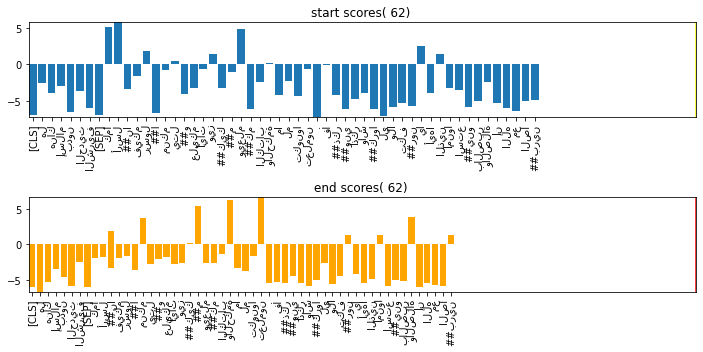

In [ ]:
print("question",question)
answer_map = answer_question(question,context,topN)
answer_steps.append( answer_map )
print( "\n".join( get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"]) ) )
plot_possible_answer(answer_map,expected_start,expected_end)

In [ ]:
_ = train_model()
acc,eval_data = eval_loader(1,dump_equals=False)
print("accuracy eval :",acc)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Elapsed time for training 38.412621 seconds.
Elapsed time for eval 1.461724 seconds.
accuracy eval : 0.37890625


In [ ]:
print( answer_map["possible_starts"] )
print( answer_map["possible_ends"] )

[ 9  8 27 23 46]
[32 26 22 54 14]


question هل هناك إسلام بدون الحديث الشريف
أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة
ويعلمكم ما لم تكونوا تعلمون

كما أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون. فاذكروني أذكركم واشكروا لي ولا تكفرون. يا أيها الذين آمنوا استعينوا بالصبر والصلاة
ويزكيكم


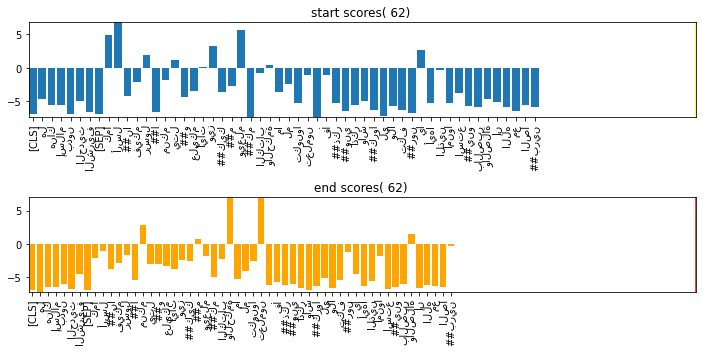

In [ ]:
print("question",question)
answer_map = answer_question(question,context,topN)
answer_steps.append( answer_map )
print( "\n".join( get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"]) ) )
plot_possible_answer(answer_map,expected_start,expected_end)



Step  1


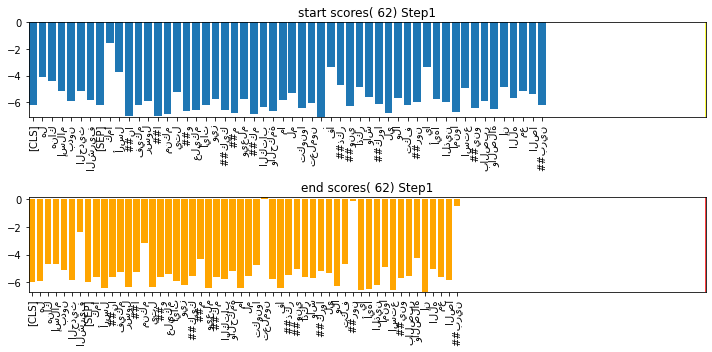



Step  2


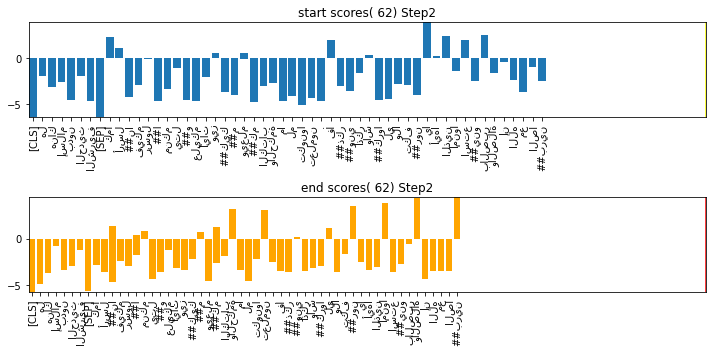



Step  3


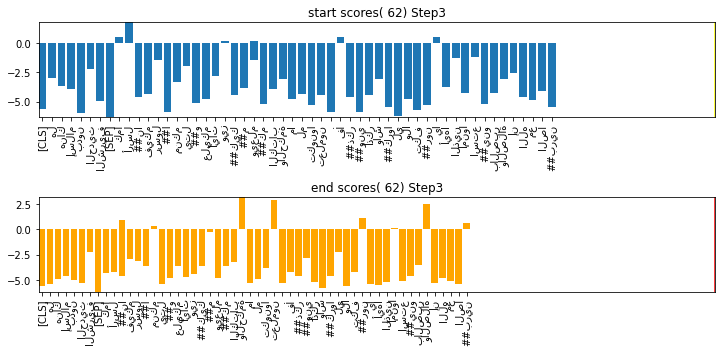



Step  4


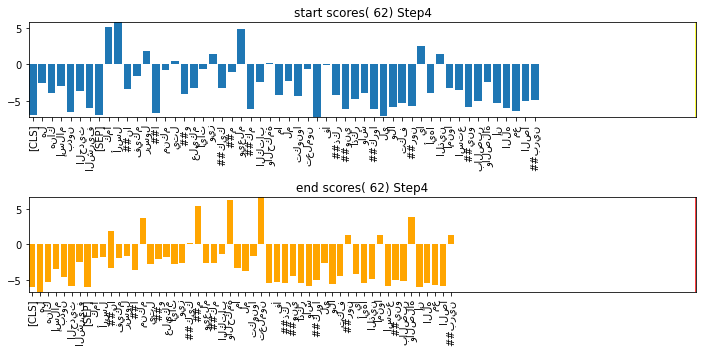



Step  5


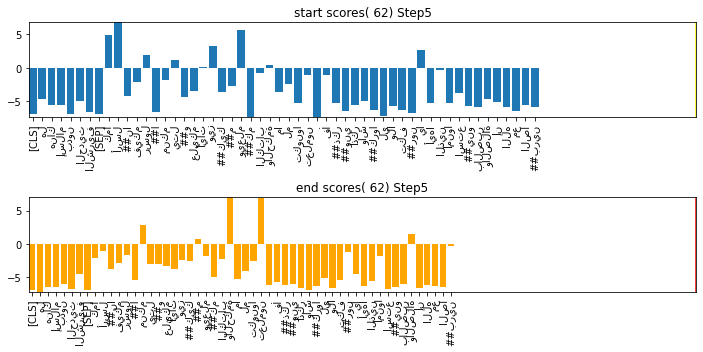

In [ ]:
for index,a_map in enumerate(answer_steps):
  print("\n\nStep ",index+1)
  plot_possible_answer(a_map,expected_start,expected_end,"Step"+str(index+1))
  plt.show()
  
  


In [ ]:
#answer_map["answer"]
print( "\n".join( get_top_answers(answer_map["possible_starts"],answer_map["possible_ends"],answer_map["input_ids"]) ) )
print("s",answer_map["possible_starts"])
print("e",answer_map["possible_ends"])

أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة
ويعلمكم ما لم تكونوا تعلمون

كما أرسلنا فيكم رسولا منكم يتلو عليكم آياتنا ويزكيكم ويعلمكم الكتاب والحكمة ويعلمكم ما لم تكونوا تعلمون. فاذكروني أذكركم واشكروا لي ولا تكفرون. يا أيها الذين آمنوا استعينوا بالصبر والصلاة
ويزكيكم
s [ 9 27 23  8 20]
e [26 32 14 54 22]


In [ ]:
#template_question = "What do you advice for GERD"
template_question = "What is treatment for Dengue"
for index,q in enumerate(val_questions):
  if q == template_question:
    print( index )

In [ ]:
sub_contexts = val_contexts[166:168]
sub_questions = val_questions[166:168]
sub_answers = val_answers[166:168]